In [1]:
import torch
import numpy as np

def torch_batch_pix_accuracy(predict, target):
  """PixAcc"""
  # inputs are numpy array, output 4D, target 3D
  assert predict.shape == target.shape
  predict = predict.type(torch.int) + 1
  target = target.type(torch.int) + 1

  pixel_labeled = torch.sum(target > 0)
  pixel_correct = torch.sum((predict == target) * (target > 0))
  assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
  return pixel_correct, pixel_labeled


def torch_batch_intersection_union(predict, target, nclass):
  """mIoU"""
  # inputs are numpy array, output 4D, target 3D
  assert predict.shape == target.shape
  mini = 1
  maxi = nclass
  nbins = nclass
  predict = predict.type(torch.int) + 1
  target = target.type(torch.int) + 1

  predict = predict * (target > 0).type(predict.dtype)
  intersection = predict * (predict == target)
  # areas of intersection and union
  # element 0 in intersection occur the main difference from np.bincount. set boundary to -1 is necessary.
  area_inter, _ = np.histogram(intersection.cpu().numpy(), bins=nbins, range=(mini, maxi))
  area_pred, _ = np.histogram(predict.cpu().numpy(), bins=nbins, range=(mini, maxi))
  area_lab, _ = np.histogram(target.cpu().numpy(), bins=nbins, range=(mini, maxi))
  area_union = area_pred + area_lab - area_inter
  assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
  return torch.tensor( area_inter, device=target.device) , torch.tensor( area_union, device=target.device)


def torch_pixelAccuracy(imPred, imLab):
  """
  This function takes the prediction and label of a single image, returns pixel-wise accuracy
  To compute over many images do:
  for i = range(Nimages):
        (pixel_accuracy[i], pixel_correct[i], pixel_labeled[i]) = \
          pixelAccuracy(imPred[i], imLab[i])
  mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
  """
  # Remove classes from unlabeled pixels in gt image.
  # We should not penalize detections in unlabeled portions of the image.
  pixel_labeled = torch.sum(imLab >= 0)
  pixel_correct = torch.sum((imPred == imLab) * (imLab >= 0))
  pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
  return (pixel_accuracy, pixel_correct, pixel_labeled)


def torch_intersectionAndUnion(imPred, imLab, numClass):
  """
  This function takes the prediction and label of a single image,
  returns intersection and union areas for each class
  To compute over many images do:
  for i in range(Nimages):
      (area_intersection[:,i], area_union[:,i]) = intersectionAndUnion(imPred[i], imLab[i])
  IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)
  """
  # Remove classes from unlabeled pixels in gt image.
  # We should not penalize detections in unlabeled portions of the image.
  imPred = imPred * (imLab >= 0)

  # Compute area intersection:
  intersection = imPred * (imPred == imLab)
  (area_intersection, _) = np.histogram(intersection.cpu().numpy(), bins=numClass, range=(1, numClass))

  # Compute area union:
  (area_pred, _) = np.histogram(imPred.cpu().numpy(), bins=numClass, range=(1, numClass))
  (area_lab, _) = np.histogram(imLab.cpu().numpy(), bins=numClass, range=(1, numClass))
  area_union = area_pred + area_lab - area_intersection
  return (torch.tensor(area_intersection, device=imPred.device) , torch.tensor(area_union, device=imPred.device))


def torch_hist_info(pred, label, num_cls):
  assert pred.shape == label.shape
  k = (label >= 0) & (label < num_cls)
  labeled = torch.sum(k)
  correct = torch.sum((pred[k] == label[k]))
  inp = num_cls * label[k].type(torch.int) + pred[k]
  inp = inp.cpu().numpy()
  return np.bincount(inp, minlength=num_cls ** 2).reshape(num_cls,num_cls), labeled, correct


def torch_compute_score(hist, correct, labeled):
  iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
  # print('right')
  # print(iu)
  mean_IU = np.nanmean(iu)
  mean_IU_no_back = np.nanmean(iu[1:])
  freq = hist.sum(1) / hist.sum()
  freq_IU = (iu[freq > 0] * freq[freq > 0]).sum()
  mean_pixel_acc = correct / labeled

  return iu, mean_IU, mean_IU_no_back, mean_pixel_acc

In [2]:
def batch_pix_accuracy(predict, target):
    """PixAcc"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    pixel_labeled = np.sum(target > 0)
    pixel_correct = np.sum((predict == target) * (target > 0))
    assert pixel_correct <= pixel_labeled, "Correct area should be smaller than Labeled"
    return pixel_correct, pixel_labeled


def batch_intersection_union(predict, target, nclass):
    """mIoU"""
    # inputs are numpy array, output 4D, target 3D
    assert predict.shape == target.shape
    mini = 1
    maxi = nclass
    nbins = nclass
    predict = predict.astype('int64') + 1
    target = target.astype('int64') + 1

    predict = predict * (target > 0).astype(predict.dtype)
    intersection = predict * (predict == target)
    # areas of intersection and union
    # element 0 in intersection occur the main difference from np.bincount. set boundary to -1 is necessary.
    area_inter, _ = np.histogram(intersection, bins=nbins, range=(mini, maxi))
    area_pred, _ = np.histogram(predict, bins=nbins, range=(mini, maxi))
    area_lab, _ = np.histogram(target, bins=nbins, range=(mini, maxi))
    area_union = area_pred + area_lab - area_inter
    assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"
    return area_inter, area_union


def pixelAccuracy(imPred, imLab):
    """
    This function takes the prediction and label of a single image, returns pixel-wise accuracy
    To compute over many images do:
    for i = range(Nimages):
         (pixel_accuracy[i], pixel_correct[i], pixel_labeled[i]) = \
            pixelAccuracy(imPred[i], imLab[i])
    mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    pixel_labeled = np.sum(imLab >= 0)
    pixel_correct = np.sum((imPred == imLab) * (imLab >= 0))
    pixel_accuracy = 1.0 * pixel_correct / pixel_labeled
    return (pixel_accuracy, pixel_correct, pixel_labeled)


def intersectionAndUnion(imPred, imLab, numClass):
    """
    This function takes the prediction and label of a single image,
    returns intersection and union areas for each class
    To compute over many images do:
    for i in range(Nimages):
        (area_intersection[:,i], area_union[:,i]) = intersectionAndUnion(imPred[i], imLab[i])
    IoU = 1.0 * np.sum(area_intersection, axis=1) / np.sum(np.spacing(1)+area_union, axis=1)
    """
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    imPred = imPred * (imLab >= 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(intersection, bins=numClass, range=(1, numClass))

    # Compute area union:
    (area_pred, _) = np.histogram(imPred, bins=numClass, range=(1, numClass))
    (area_lab, _) = np.histogram(imLab, bins=numClass, range=(1, numClass))
    area_union = area_pred + area_lab - area_intersection
    return (area_intersection, area_union)


def hist_info(pred, label, num_cls):
    assert pred.shape == label.shape
    k = (label >= 0) & (label < num_cls)
    labeled = np.sum(k)
    correct = np.sum((pred[k] == label[k]))

    return np.bincount(num_cls * label[k].astype(int) + pred[k], minlength=num_cls ** 2).reshape(num_cls,
                                                                                                 num_cls), labeled, correct


def compute_score(hist, correct, labeled):
    iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    # print('right')
    # print(iu)
    mean_IU = np.nanmean(iu)
    mean_IU_no_back = np.nanmean(iu[1:])
    freq = hist.sum(1) / hist.sum()
    freq_IU = (iu[freq > 0] * freq[freq > 0]).sum()
    mean_pixel_acc = correct / labeled

    return iu, mean_IU, mean_IU_no_back, mean_pixel_acc

In [7]:
BS,W,H = 2,400,400
pred = torch.randint(low=0,high=19,size=(BS,W,H))
target = torch.randint(low=0,high=19,size=(BS,W,H))
torch_batch_pix_accuracy(pred, target), batch_pix_accuracy(pred.numpy(), target.numpy())

torch_batch_intersection_union(pred, target,19), batch_intersection_union(pred.numpy(), target.numpy(),19)



((tensor([941, 901, 921, 871, 914, 869, 922, 818, 844, 874, 866, 913, 912, 878,
          925, 831, 868, 894, 865]),
  tensor([32893, 32822, 32750, 32846, 32995, 32801, 33098, 32665, 32773, 32844,
          32433, 32660, 32977, 32880, 33011, 32919, 32675, 32568, 32563])),
 (array([941, 901, 921, 871, 914, 869, 922, 818, 844, 874, 866, 913, 912,
         878, 925, 831, 868, 894, 865]),
  array([32893, 32822, 32750, 32846, 32995, 32801, 33098, 32665, 32773,
         32844, 32433, 32660, 32977, 32880, 33011, 32919, 32675, 32568,
         32563])))

In [8]:
# lambda learning rate calculator 

target_lr + (base_lr - target_lr) * pow(1 - T / N, power)



20

In [10]:
"""Popular Learning Rate Schedulers"""
from __future__ import division
import math


class LRScheduler(object):
    r"""Learning Rate Scheduler
    Parameters
    ----------
    mode : str
        Modes for learning rate scheduler.
        Currently it supports 'constant', 'step', 'linear', 'poly' and 'cosine'.
    base_lr : float
        Base learning rate, i.e. the starting learning rate.
    target_lr : float
        Target learning rate, i.e. the ending learning rate.
        With constant mode target_lr is ignored.
    niters : int
        Number of iterations to be scheduled.
    nepochs : int
        Number of epochs to be scheduled.
    iters_per_epoch : int
        Number of iterations in each epoch.
    offset : int
        Number of iterations before this scheduler.
    power : float
        Power parameter of poly scheduler.
    step_iter : list
        A list of iterations to decay the learning rate.
    step_epoch : list
        A list of epochs to decay the learning rate.
    step_factor : float
        Learning rate decay factor.
    """

    def __init__(self, mode, base_lr=0.01, target_lr=0, niters=0, nepochs=0, iters_per_epoch=0,
                 offset=0, power=2, step_iter=None, step_epoch=None, step_factor=0.1):
        super(LRScheduler, self).__init__()
        assert (mode in ['constant', 'step', 'linear', 'poly', 'cosine'])

        self.mode = mode
        if mode == 'step':
            assert (step_iter is not None or step_epoch is not None)
        self.base_lr = base_lr
        self.target_lr = target_lr
        if self.mode == 'constant':
            self.target_lr = self.base_lr

        self.niters = niters
        self.step = step_iter
        epoch_iters = nepochs * iters_per_epoch
        if epoch_iters > 0:
            self.niters = epoch_iters
            if step_epoch is not None:
                self.step = [s * iters_per_epoch for s in step_epoch]

        self.offset = offset
        self.power = power
        self.step_factor = step_factor

    def __call__(self, num_update):
        self.update(num_update)
        return self.learning_rate

    def update(self, num_update):
        N = self.niters - 1
        T = num_update - self.offset
        T = min(max(0, T), N)

        if self.mode == 'constant':
            factor = 0
        elif self.mode == 'linear':
            factor = 1 - T / N
        elif self.mode == 'poly':
            factor = pow(1 - T / N, self.power)
        elif self.mode == 'cosine':
            factor = (1 + math.cos(math.pi * T / N)) / 2
        elif self.mode == 'step':
            if self.step is not None:
                count = sum([1 for s in self.step if s <= T])
                factor = pow(self.step_factor, count)
            else:
                factor = 1
        else:
            raise NotImplementedError

        if self.mode == 'step':
            self.learning_rate = self.base_lr * factor
        else:
            self.learning_rate = self.target_lr + (self.base_lr - self.target_lr) * factor


if __name__ == '__main__':
    lr_scheduler = LRScheduler(mode='poly', base_lr=0.01, nepochs=10,
                               iters_per_epoch=176, power=0.9)
    for i in range(60 * 176):
        lr = lr_scheduler(i)
        
        print(lr)

0.01
0.00999488331104007
0.009989766331020139
0.009984649059757985
0.009979531497071153
0.009974413642776986
0.009969295496692598
0.009964177058634885
0.009959058328420527
0.009953939305865982
0.00994881999078749
0.009943700383001063
0.009938580482322502
0.009933460288567382
0.009928339801551053
0.009923219021088649
0.009918097946995077
0.00991297657908502
0.009907854917172944
0.009902732961073085
0.009897610710599455
0.009892488165565849
0.009887365325785824
0.009882242191072723
0.009877118761239659
0.009871995036099519
0.00986687101546496
0.00986174669914842
0.009856622086962101
0.009851497178717984
0.009846371974227814
0.009841246473303119
0.009836120675755183
0.009830994581395074
0.009825868190033624
0.009820741501481434
0.009815614515548876
0.00981048723204609
0.009805359650782986
0.00980023177156924
0.009795103594214299
0.00978997511852737
0.009784846344317437
0.009779717271393241
0.009774587899563295
0.009769458228635876
0.009764328258419021
0.009759197988720544
0.00975406741934

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


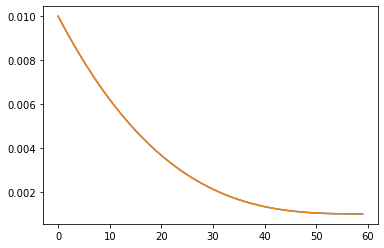

In [46]:

power = 3
max_epoch = 60
lambda_lr= lambda epoch: power ** epoch 
init_lr = 0.01
target_lr = 0.001

lambda_lr= lambda epoch: (((max_epoch -epoch)/max_epoch)**(power) ) + (1-(((max_epoch -epoch)/max_epoch)**(power)))*target_lr/init_lr
# for scale init_lr to 0 the factor
l1 = []
l2 = []

if __name__ == '__main__':
    lr_scheduler = LRScheduler(mode='poly', base_lr=0.01, nepochs=60,target_lr= target_lr,
                               iters_per_epoch=176, power=power)
    for i in range(60 * 176):
        lr = lr_scheduler(i)
        #print(lr)
        
        if i % 176 == 0:
            lr = lr_scheduler(i)
            l2.append( lr )
            l1.append( lambda_lr(i/176)*0.01 )
            

x = list( range( 0, len(l1)) )

import matplotlib.pyplot as plt
plt.plot(x, l2)
plt.plot(x, l1)
#plt.axis([0, 6, 0, 20])
plt.show()
